Multi-electrode recording of a few dozens of neurons in the prefrontal cortex of alive rats were performed in Refs. [1,2]. A single recording session is divided into three epochs: a task epoch in which a rat has to learn what is the rewarded arm in a Y-shaped maze; and two sleep epochs, one before and one after the task epoch. The goal of this tutorial is to analyze the recorded data using PCA and tools from random matrix theory, in order to detect similarities between the neuronal activity during the task and post-task sleep epochs, which where not present in the pre-task sleep epoch.

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix
import numpy.matlib
from numpy import linalg as LA

In [3]:
# Each data file consists of two columns, with one row per spike:
# the first column is the spiking time, the second column the neuron index.
datatask = np.loadtxt('/data/Dati_181014_maze.txt').astype(int)
datapre = np.loadtxt('/data//Dati_181014_sleep1.txt').astype(int)
datapost = np.loadtxt('/data/Dati_181014_sleep2.txt').astype(int)

### Question 1

Read the data and produce the raster plot for the $L$ neurons and the first $10$ seconds of activity. Note that in reading the data, you should find $T_{min}$ and $T_{max}$ for each epoch.

### Question 2

**Question 2a.** For each dataset, construct matrices $S_{task}$, $S_{pre}$, $S_{post}$, of dimensions $M \times L$, where $M$ is the number of time bins (varies for each dataset), and $L$ the number of neurons ($L=37$). Discretize time using time-bins of 100ms, and start at the $T_{min}$ corresponding to each dataset. Then matrix entry $S_{b,i}$ should give the number of spikes of neuron $i$ in time-bin $b$, for a given dataset.

In [4]:
# recall that the data uses a time-unit of 0.1ms

dt = int(100/0.1) #delta-time for each time-bin
L=37 

print(dt)


1000


In [5]:
#discretize_data functions takes continuous time-spiking data and discretises it into time bins
#create a matrix S (M X L), with each element showing the number of spiking events for each neuron in a given time bin

#function discretize_data takes three arguments: 'data', 'dt' and 'L'. 'data' is assumed to be a NumPy array, while dt and : are optional parameters with default values of 'int(100.0.1)' and '37'
#100/0.1 divide the wished time bin (100ms) by the dime in the data (0.1 ms)
#Tmin and Tmax are the starting and finishing times of the data
#S is an initialised array of zeros
def discretize_data(data, dt=int(100/0.1), L=37):
    Tmin = np.min(data[:,0])
    Tmax = np.max(data[:,0])
    
    #rows: (Tmax-Tmin) // dt + 1 ; 1 is added to ensure any leftover (less than dt) at the end of the time span is also considered
    #columns: L
    S = np.zeros(((Tmax-Tmin) // dt + 1, L), dtype=int)
    
    #loop considering the spiking event to fill zero array
    #it iterates trhough 'data' array, which is assumed to contain pairs of 't' (timestamp) and 'i' (neuron index) values
    #calculates the row index in the 'S' array as '(t-Tmin)//dt' to determine in which time bin the event belongs to
    #uses 'i-1' as the columns index as it assumes neuron indices are 1-based (whereas pyhton is 0-based)
    #the value at that location in the 'S' array is incremented by 1 for each spiking event
    for t, i in data:
        S[(t-Tmin) // dt, i-1] +=1
    return S

In [6]:
Stask = discretize_data (datatask, dt, L)
Spre = discretize_data (datapre, dt, L)
Spost = discretize_data (datapost, dt, L)

Stask


array([[0, 0, 1, ..., 0, 1, 1],
       [1, 0, 0, ..., 2, 1, 2],
       [0, 0, 0, ..., 1, 0, 1],
       ...,
       [0, 0, 0, ..., 2, 0, 4],
       [0, 0, 0, ..., 0, 0, 3],
       [0, 0, 0, ..., 0, 0, 1]])

**Question 2b.** For each dataest, compute the *z-score* matrices, defined by $y_{bi} = (S_{bi} - p_i) / \sigma_i$, where:

$$p_i = \frac{1}{M}\sum_{b=1}^M S_{b,i},\qquad
\sigma_i^2 = \frac{1}{M-1}\sum_{b=1}^M (S_{b,i} - p_i)^2$$

In [8]:
# Standardize data (subtract mean, and divide by standard deviation).
# The resulting data has zero mean and unit variance.

def zscore(S):
    p = S.mean(axis=0) #calculate mean along the rows, you will get one average value from all time-bins per neuron
    v = np.sum((S-p)**2, axis = 0) / (S.shape[0]-1) #variance, check formula, calculate variance per neuron across time-bins
    return (S - p) / np.sqrt (v) #Check formula again to see relationship between average, variance and z-score


In [10]:
Z_task = zscore(Stask)
Z_pre = zscore(Spre)
Z_post= zscore(Spost)

Z_task.shape

(14086, 37)

**Question 2c.** Compute the Pearson correlation matrix of the task activity (using the z-scores) and diagonalize it. Compare the spectrum of eigenvalues of $C^{task}$ to the Marcenko-Pastur (MP) distribution to extract the signal components associated to large eigenvalues. How many signal components (eigenvalues outside the MP bulk) are present?


**Reminder:** The Marcenko-Pastur (MP) distribution describes the eigenvalue density of the empirical covariance matrix of random, normally distributed data. If $r=L/M$ denotes the ratio between the dimension of the data ($L$) and the number of observations ($M$),

$$\rho_{MP}(x) = \begin{cases}
\frac{\sqrt{(l_+ - x)(x - l_-)}}{2\pi r x} & l_- < x < l_+ \\
0 & \textrm{otherwise}
\end{cases}$$

where $l_\pm = (1\pm\sqrt r)^2$



The Marcenko-Pastur distribution is a theoretical distribution that describes the expected distribution of eigenvalues for a random matrix when its elements are drawn from a Gaussian distribution. In the context of covariance or correlation matrices, eigenvalues inside the support region of the Marcenko-Pastur distribution are considered noise, and those outside the support region are considered signal. When you compute the eigenvalues of an empirical covariance or correlation matrix and compare them to the Marcenko-Pastur distribution, eigenvalues outside the expected range indicate the presence of non-random structure or patterns in the data. These are often referred to as "signal" eigenvalues and may correspond to meaningful features or relationships in the data that are not simply a result of random fluctuations.


r (signal-to-noise ratio): number of variables number of observations/ number of observations number of variables.

lp (upper bound of Marčenko-Pastur distribution): It is used to define the x-axis range when plotting the Marčenko-Pastur distribution. 

lm (lower bound of Marčenko-Pastur distribution): It is used to define the x-axis range when plotting the Marčenko-Pastur distribution.


Diagonalizing a correlation matrix involves finding its eigenvalues and eigenvectors. The process of diagonalization transforms the correlation matrix into a diagonal matrix, which is a matrix with zeros everywhere except on the main diagonal. Each eigenvalue corresponds to a diagonal entry, and the corresponding eigenvector represents a principal component or a direction in which the data varies.

In [67]:
#To compute correlation matrix between neurons, perform matrix product across time index -> this will give you the correlations of neurons based on their spiking times

C_task = (Z_task.T @ Z_task) / Z_task.shape[0]
C_pre = (Z_pre.T @ Z_pre) / Z_pre.shape[0]
C_post = (Z_post.T @ Z_post) / Z_post.shape[0]

print(C_task)
print(C_pre)
print(C_post)


[[ 0.99992901 -0.02309731 -0.02094818 ... -0.00742088  0.01576233
   0.11525794]
 [-0.02309731  0.99992901  0.01912614 ... -0.00880213 -0.01367053
  -0.00654998]
 [-0.02094818  0.01912614  0.99992901 ...  0.00838751  0.01258686
  -0.01065727]
 ...
 [-0.00742088 -0.00880213  0.00838751 ...  0.99992901 -0.02474536
  -0.03918334]
 [ 0.01576233 -0.01367053  0.01258686 ... -0.02474536  0.99992901
   0.01760205]
 [ 0.11525794 -0.00654998 -0.01065727 ... -0.03918334  0.01760205
   0.99992901]]
[[ 9.99943496e-01 -6.40022133e-03 -5.08520340e-03 ... -7.48820260e-03
   8.20516286e-04  2.11310026e-02]
 [-6.40022133e-03  9.99943496e-01  7.39879545e-03 ...  1.23074766e-03
   3.98885505e-03 -4.83218536e-04]
 [-5.08520340e-03  7.39879545e-03  9.99943496e-01 ...  6.32175210e-03
  -1.81999819e-02 -5.57711036e-03]
 ...
 [-7.48820260e-03  1.23074766e-03  6.32175210e-03 ...  9.99943496e-01
  -4.84017899e-03 -2.66652568e-03]
 [ 8.20516286e-04  3.98885505e-03 -1.81999819e-02 ... -4.84017899e-03
   9.99943496

In [15]:
#compare the Marcenko Pastur distribution to the eigenvalues of the datasets
#Diagonalise the correlation matrix to find its eigenvalues and eigenvectors

def spectra_mp_plot (Z, title = 'spectra', xlim=None, ylim=None):
    #To compute correlation matrix between neurons, perform matrix product across time index 
    #-> this will give you the correlations of neurons based on their spiking times
    C = (Z.T @ Z) / Z.shape[0] 
    # diagonalise correlation matrix:
    #w will contain an array of eigenvalues of matrix C, 
    #v will contain a 2D array with each column representing an eigenvector corresponding to eigenvalues stored in array w
    w, v = np.linalg.eig(C)  

    r = Z.shape[1] / Z.shape[0] #r=L/M
    lp = (1 + np.sqrt(r))**2 #l+
    lm = (1 - np.sqrt(r))**2 #l-

    mp_x = np.linspace(lm,lp, 100) #x-axis of MP distribution, between lm and lp with 100 divisions
    mp_y = np.sqrt((lp-mp_x)*(mp_x-lm))/ (2 * np.pi * r * mp_x)


    print (f'Number of eigenvalues > lp: {np.count_nonzero(w>lp)}') #get the number of eigenvalues out of the MP distribution (signal!)

    plt.figure(figsize=(7,4))
    plt.hist(w, bins=10, density=True, facecolor='grey') #put histogram of eigenvalues
    plt.plot(mp_x, mp_y, 'black') #plot MP distribution
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('eigenvalues')
    plt.ylabel('density')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [50]:
w[0]


array([2.15053293, 1.46432679, 0.53128655, 1.33707928, 1.30636579,
       0.69696058, 0.74185272, 1.16323993, 0.76917917, 0.79080551,
       1.12384063, 0.81296935, 1.10377538, 0.8328343 , 1.07548894,
       0.85226474, 0.85943761, 0.87005851, 1.06457998, 0.87962484,
       1.05440046, 1.04721044, 0.89682443, 0.9064936 , 0.91578149,
       1.02957219, 1.02187052, 1.01354449, 1.00185717, 0.99708919,
       0.92844148, 0.93171265, 0.97791119, 0.97302608, 0.96778094,
       0.95703972, 0.95031369])

In [58]:
print(v)
print(v[0])

[[-0.30575564  0.06147327 -0.18544392 ...  0.05561082 -0.14650087
  -0.01089771]
 [ 0.011962    0.01871545  0.00527686 ...  0.23089254 -0.14530469
   0.36408111]
 [ 0.00778311 -0.03735939 -0.00254646 ... -0.18031273 -0.13564215
   0.08028695]
 ...
 [-0.12028375 -0.30237844 -0.0694377  ... -0.03045159 -0.02636261
   0.10447435]
 [ 0.02597055 -0.05485016  0.01844873 ...  0.14277403 -0.15220266
  -0.26092432]
 [-0.09338114  0.11793019 -0.02765853 ...  0.02586792  0.34085767
   0.13610945]]
[-0.30575564  0.06147327 -0.18544392 -0.3249445  -0.08758395 -0.13832533
 -0.51403662 -0.09355569  0.34573998  0.23364155  0.0611593  -0.05681536
 -0.01592486 -0.1073051   0.09296234 -0.05430324  0.10494099  0.25329917
  0.09628439  0.00765931 -0.0910577  -0.1035783  -0.05335282  0.07562895
 -0.27201556  0.027858   -0.06518442  0.05324904 -0.0203655  -0.09359677
  0.09760077 -0.08083183  0.06891661  0.09956612  0.05561082 -0.14650087
 -0.01089771]


Number of eigenvalues > lp: 6


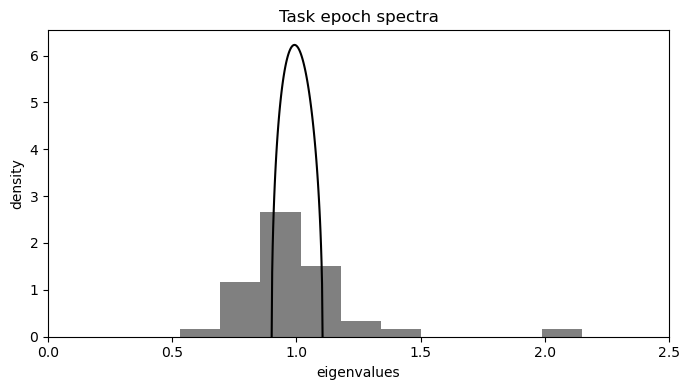

In [16]:
spectra_mp_plot(Z_task, title='Task epoch spectra', xlim=(0, 2.5))

Number of eigenvalues > lp: 6


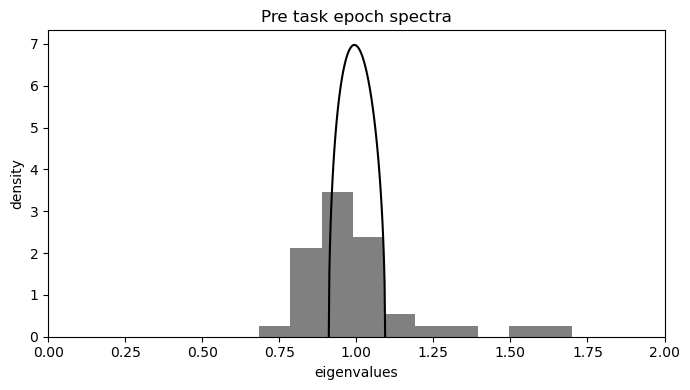

In [17]:
spectra_mp_plot(Z_pre,title='Pre-task sleep epoch spectra', xlim=(0, 2.0))

Number of eigenvalues > lp: 6


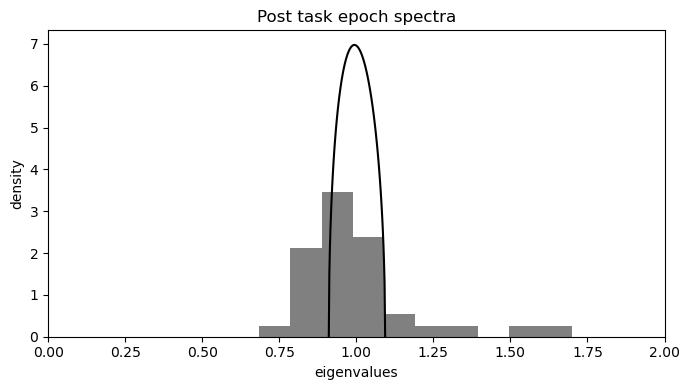

In [18]:
spectra_mp_plot(Z_post,title='Post-task sleep epoch spectra', xlim=(0, 2.0))

### Question 3

Apply a random permutation to the activity of single neurons over the $M$ possible time bins, in such a way that the correlations between neurons spiking together are lost, but the frequencies of individual neurons are kept constant. Verify that the spectrum of the eigenvalues of the Pearson correlation matrix of the shuffled data is well described by the Marcenko-Pastur distribution.

In [19]:
#If you shuffle the activity all the eigenvalues should fall in the MP distribution
def shuffle_activity(Z):
    Zs=np.copy(Z) #create copy of original array
    for i in range (Z.shape[1]): #iterate thorough all neuron
        _p= np.random.permutation(Z.shape[0]) #randomly shuffle the time-bins
        Zs[:,i] = Z[_p, i] #for each i neuron in Zs, replace the corresponding rows with the shuffled ones from _p
    return Zs


Number of eigenvalues > lp: 0


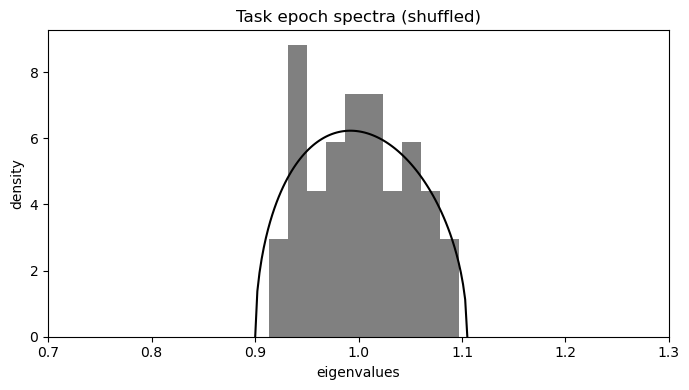

In [21]:
spectra_mp_plot(shuffle_activity(Z_task), 
                title='Task epoch spectra (shuffled)', 
                xlim=(0.7, 1.3))

Number of eigenvalues > lp: 0


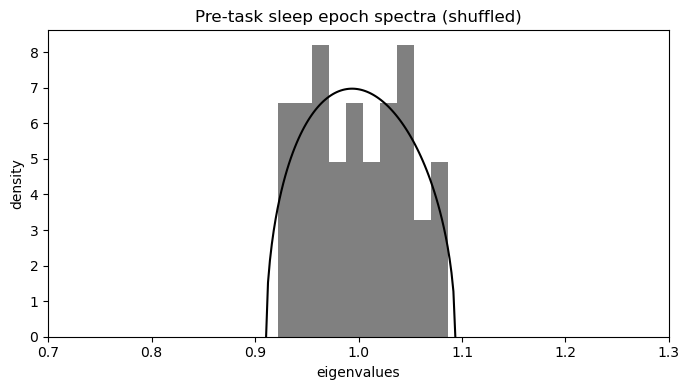

In [22]:
spectra_mp_plot(shuffle_activity(Z_pre), 
                title='Pre-task sleep epoch spectra (shuffled)', 
                xlim=(0.7, 1.3))

Number of eigenvalues > lp: 0


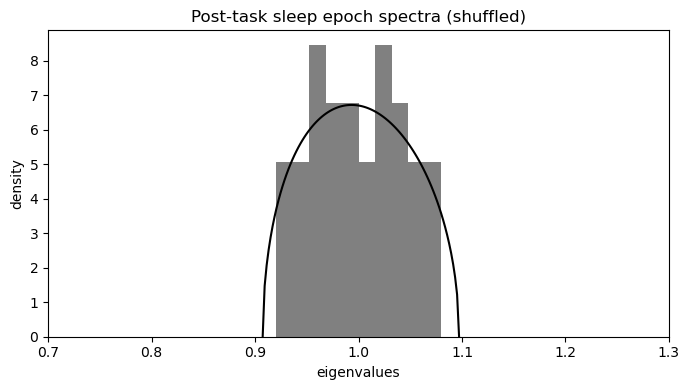

In [23]:
spectra_mp_plot(shuffle_activity(Z_post), 
                title='Post-task sleep epoch spectra (shuffled)', 
                xlim=(0.7, 1.3))

### Question 4

Identify the neurons that contribute the most to the largest component of the task activity. These neurons identify a cell assembly of neurons coactivating during the task.

In [ ]:
#Calculate eigenvalues and eigenvector for the task

w, v = np.linalg.eig((Z_task.T @ Z_task) / Z_task.shape[0])


#Identify neurons corresponding to the largest eigenvalue
#This identifies which ones contribute the most to the largest component


#1 dimensions array representing the amount of variance captured by the top eigenvector
print(f'top eigval: {w[0]}')

#37 dimensional array that represent the direction of the original feature space 
#where data varies the most
print(f'top eigvector: {v[:,0]}') #for each of the 37 there are 37 vectors


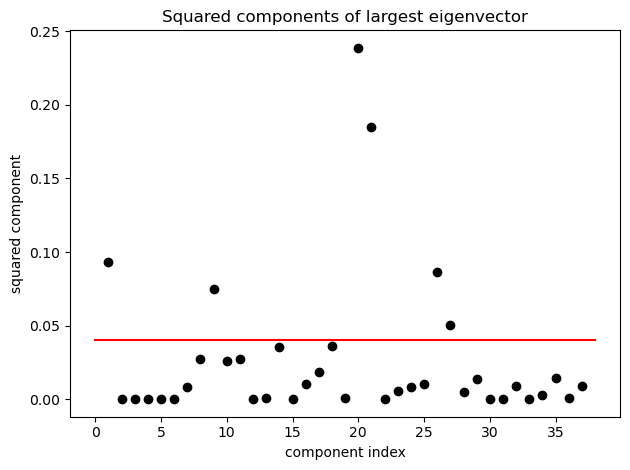

neuron assembly:  (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36]),)
neuron assembly:  [ 1  9 20 21 26 27]


In [40]:
#Plot

#write an array from 1 up to but not including v.shape[0]+1 (so it includes)
#by adding +1 it passes the fact that np.arrange does not include the 'stop' number
plt.plot(np.arange(1, v.shape[0]+1), v[:,0]**2, 'ko') #shows eigenvectors of neurons for largest eigenvalue

#write an horizontal line set to y = 0.2^2
#x-values go from 0 to v.shape[0]+1
plt.plot([0, v.shape[0]+1], [0.2**2, 0.2**2], 'red')
plt.title('Squared components of largest eigenvector')
plt.xlabel('component index')
plt.ylabel('squared component')
plt.tight_layout()
plt.show()

#Print the names of the neurons that are above the threshold

#check if you have eigenvectors that have number > 0.2, reuslting in a boolean array
#np.where returns the indices of the True values in the boolean tuple
#[0] access the first array of the tuple containing the indices
#+1 converts from the 0 based to the 1 based
print('neuron assembly: ', np.where(abs(v[:,0])))
print('neuron assembly: ', np.where(abs(v[:,0]) > 0.2)[0]+1)


**Interpretation**

FIGURE THIS OUT

These are the neurons that co-activate in the task and that contribute the most to the principal component of the task activity (i.e. their eigenvector contribute the most to the maximal eigenvalue)



Neurons with squared components above this threshold are considered significant contributors to the principal component.

This approach helps identify and focus on the most relevant features or neurons contributing to the dominant patterns in the data. 

### Question 5

Following Peyrache et al [1,2], we define an instantaneous measure of similarity between the task epoch, and the pre- and post- task sleep epochs, by:

$$R^{match}(b) = \frac{1}{2} \sum_{i\ne j} y_{bi}^{match} C_{ij}^{task} y_{bj}^{match}$$

where $match$ denotes one of the two sleep epochs (pre- or post-). We then define the *total replay* as the average of $R^{match}(b)$ over time,

$$R^{match} = \frac{1}{2M}\sum_b\sum_{i\ne j} y_{bi}^{match} C_{ij}^{task} y_{bj}^{match}$$

Compute the total replay of the Sleep Pre and Sleep Post epochs.

In [68]:
I = np.identity(L) #create an identity matrix of size LxL

#measure similarity between pre and post-task sleep epochs and the task
#compare covariance matrix of pre with task
#substract the identity matrix (as diagonals are equal to 1) from C_pre and then perform matrix product 
#np.trace calculates the trace of the matrix: sum of the diagonal elements
#the trace captures the similarity between the patterns of neural activity
#dividing by 2 normalises the measure
R_pre  = np.trace((C_pre - I)  @ (C_task - I)) / 2

#compare covariance matrix of post with task
R_post = np.trace((C_post - I) @ (C_task - I)) / 2

print(R_pre, R_post)


0.2907080442794488 0.5480941612056212


The fact that the replay in the pre-task sleep epoch is significatively smaller than that in the post-task sleep epoch suggests that the higher replay in the post-task sleep is associated with the learning process during the task epoch.

### Question 6

Using the eigenvalue decomposition of the Pearson correlation matrix of the task epoch,

$$C_{ij}^{task} = \sum_k \lambda_k v_i^k v_j^k$$

where $\lambda_k,v_i^k$ are the eigenvalues and eigenvectors, show that the instantaneous replay can be decomposed as a sum of replays for each component:

$$R^{match}(b) = \sum_k\lambda_k R_k^{match}(b)$$

where 

$$R_k^{match}(b)=\frac{1}{2}\left[ \left(\sum_i y_{bi}^{match} v_i^k\right)^2 -
\sum_i (y_{bi}^{match} v_i^k)^2 \right]$$

Plot the replay of the first component over time in Sleep Pre and in Sleep Post epochs.

In [71]:
#Compute eigenvalues and eigen vectors for task, 

w, v = np.linalg.eig((Z_task.T @ Z_task) / Z_task.shape[0])

#v[:,0] -> select all elements of the first coloumn of the eigenvectors (which is the one containing the info of the principal component)
#Computes the element-wise multiplication of each element in Z_pre with the corresponding element in the first principal component (v[:,0]).
#The sum(axis=1) part then sums the squared values along each row, resulting in a 1D array of sums for each data point.

R_pre = (np.square(Z_pre @ v[:,0]) - np.square(Z_pre * v[:,0]).sum(axis=1)) / 2
R_post = (np.square(Z_post @ v[:,0]) -  np.square(Z_post * v[:,0]).sum(axis=1)) / 2

time_pre = np.linspace(0, len(R_pre) * dt / 10000, len(R_pre))
time_post = np.linspace(0, len(R_post) * dt / 10000, len(R_post))


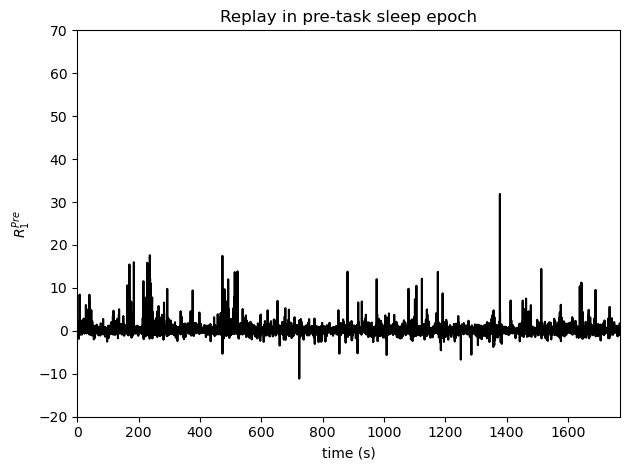

In [72]:
plt.plot(time_pre, R_pre, 'k')
plt.title('Replay in pre-task sleep epoch')
plt.xlabel('time (s)')
plt.ylabel('$R_1^{Pre}$')
plt.xlim(0, np.max(time_pre))
plt.ylim([-20, 70])
plt.tight_layout()
plt.show()

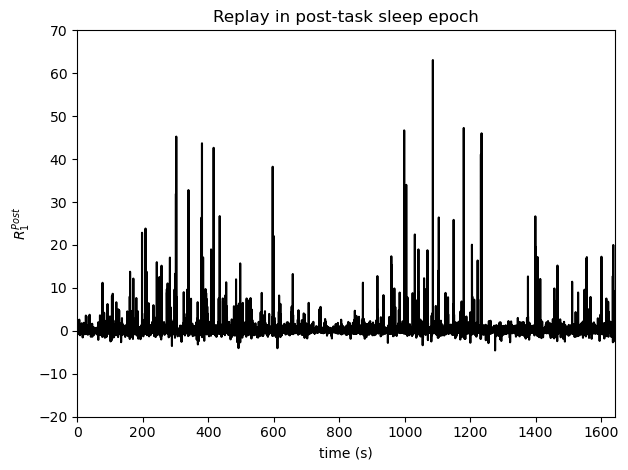

In [73]:
plt.plot(time_post, R_post, 'k')
plt.title('Replay in post-task sleep epoch')
plt.xlabel('time (s)')
plt.xlim(0, np.max(time_post))
plt.ylim([-20, 70])
plt.ylabel('$R_1^{Post}$')
plt.tight_layout()
plt.show()
